 # Claim Analysis and Visualization

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
from matplotlib.patheffects import withStroke
import plot_info

In [ ]:
# Load data
df = pd.read_csv('preprocessed_data/claims_db_truncated_for_llm.csv')
df["assessment_type"].unique()

FileNotFoundError: [Errno 2] No such file or directory: 'preprocessed_data/claims_truncated_for_llm.csv'

In [ ]:
df[["assertion_type"]].value_counts()

assertion_type    
assessment            6423
evidence              3886
major_claim           1006
minor_claim            590
main_claim             400
reference              399
method                 393
comment                148
additional_context      54
Name: count, dtype: int64

In [ ]:
major_claims_df = df[df['assertion_type'] == 'major_claim']
print(len(major_claims_df))
major_claims_df

1006


,content,article_id,rank,pmid,authors_txt,title,pmid_article,volume,issue,abstract,...,large_scale,nber_tables,nber_panels,journal_name,impact_factor,assertion_type,label,is_assessed,assessment_type,rank_assessment_type
8,#gene:FBgn0000279 is...,3103.0,2,NaN,Tryselius Y;Samakovl...,"CecC, a cecropin gen...",1740152.0,204,1,Cecropins are antiba...,...,False,0.0,10.0,European journal of biochemistry,5.4,major_claim,Major claim,True,Verified,1.0
30,Hemocyte proliferati...,2204.0,3,NaN,Zettervall CJ;Anderl...,A directed screen fo...,15381778.0,101,39,An attack by a paras...,...,False,2.0,9.0,Proceedings of the National Academy of Science...,11.1,major_claim,Major claim,True,Verified,1.0
31,The Ras/MAPK pathway...,2204.0,1,NaN,Zettervall CJ;Anderl...,A directed screen fo...,15381778.0,101,39,An attack by a paras...,...,False,2.0,9.0,Proceedings of the National Academy of Science...,11.1,major_claim,Major claim,True,Verified,1.0
37,The JAK/STAT and JNK...,2204.0,2,NaN,Zettervall CJ;Anderl...,A directed screen fo...,15381778.0,101,39,An attack by a paras...,...,False,2.0,9.0,Proceedings of the National Academy of Science...,11.1,major_claim,Major claim,True,Verified,1.0
110,#gene:FBgn0035976 fu...,2520.0,2,NaN,Gottar M;Gobert V;Mi...,The Drosophila immun...,11912488.0,416,6881,The antimicrobial de...,...,False,NaN,NaN,Nature,64.8,major_claim,Major claim,True,Verified,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13261,Ehrlichia chaffeensi...,1593.0,1,NaN,Luce-Fedrow A;Von Oh...,Ehrlichia chaffeensi...,19687202.0,77,11,Ehrlichia chaffeensi...,...,False,0.0,15.0,Infection and immunity,3.1,major_claim,Major claim,True,"Unchallenged, logically consistent",6.0
13264,B. bassiana inhibits...,1532.0,2,NaN,Matskevich AA;Quinti...,The Drosophila PRR G...,20201042.0,40,5,The Drosophila Toll-...,...,False,0.0,26.0,European journal of immunology,5.4,major_claim,Major claim,True,"Unchallenged, logically consistent",6.0
13270,A polyclonal antibod...,3004.0,2,NaN,Georgel P;Kappler C;...,Drosophila immunity....,7537872.0,23,7,Bacterial challenge ...,...,False,1.0,10.0,Nucleic acids research,14.9,major_claim,Major claim,True,"Unchallenged, logically inconsistent",7.0
13273,A pathway in additio...,2874.0,3,NaN,Wu LP;Anderson KV,Regulated nuclear im...,9510254.0,392,6671,The Drosophila immun...,...,False,0.0,16.0,Nature,64.8,major_claim,Major claim,True,"Unchallenged, logically inconsistent",7.0


In [ ]:
major_claims_df[["assessment_type"]].value_counts()

assessment_type                      
Verified                                 559
Unchallenged, logically consistent       111
Unchallenged                             107
Partially verified                        75
Verified by same authors                  44
Challenged by reproducibility project     38
Challenged                                26
Unchallenged, logically inconsistent      22
Mixed                                     12
Verified by reproducibility project        7
Challenged by same authors                 5
Name: count, dtype: int64

In [ ]:
# Apply categorizations - using .loc to avoid SettingWithCopyWarning
major_claims_df.loc[:, 'journal_category'] = major_claims_df['impact_factor'].apply(plot_info.categorize_journal)
major_claims_df.loc[:, 'assessment_group'] = major_claims_df['assessment_type'].apply(plot_info.group_assessment)

# Display distribution of journal categories
print(f"Journal Category Distribution:")
print(major_claims_df['journal_category'].value_counts())
print("\nAssessment Group Distribution:")
print(major_claims_df['assessment_group'].value_counts())


Journal Category Distribution:
journal_category
Low Impact         635
High Impact        246
Trophy Journals    125
Name: count, dtype: int64

Assessment Group Distribution:
assessment_group
Verified              610
Unchallenged          240
Partially Verified     75
Challenged             69
Mixed                  12
Name: count, dtype: int64


/var/folders/pj/15hxgl0j1wg2w_t5k7bvnq5c0000gn/T/ipykernel_11588/892573795.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  major_claims_df.loc[:, 'journal_category'] = major_claims_df['impact_factor'].apply(plot_info.categorize_journal)
/var/folders/pj/15hxgl0j1wg2w_t5k7bvnq5c0000gn/T/ipykernel_11588/892573795.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  major_claims_df.loc[:, 'assessment_group'] = major_claims_df['assessment_type'].apply(plot_info.group_assessment)


In [ ]:
unique_pairs = major_claims_df[["journal_name", "impact_factor"]].drop_duplicates().sort_values("impact_factor", ascending=False)
for index, row in unique_pairs.iterrows():
    # Count occurrences of this journal in major_claims
    count = len(major_claims_df[major_claims_df["journal_name"] == row["journal_name"]])
    print(f"{row['impact_factor']:.1f}\t{row['journal_name']} ({count} claims)")


64.8	Nature (20 claims)
64.5	Cell (15 claims)
56.9	Science (New York, N.Y.) (27 claims)
32.4	Immunity (24 claims)
30.5	Nature immunology (28 claims)
30.3	Cell host & microbe (11 claims)
16.0	Molecular cell (8 claims)
14.9	Nucleic acids research (11 claims)
14.8	Nature protocols (1 claims)
11.8	Developmental cell (24 claims)
11.4	The EMBO journal (56 claims)
11.1	Proceedings of the National Academy of Sciences of the United States of America (119 claims)
10.5	Genes & development (25 claims)
10.3	National Cancer Institute monograph (2 claims)
9.8	PLoS biology (19 claims)
9.3	Experientia (1 claims)
9.2	Current biology : CB (36 claims)
9.1	EMBO reports (31 claims)
7.8	The Journal of cell biology (1 claims)
7.8	The Journal of biophysical and biochemical cytology (2 claims)
7.8	Aging cell (6 claims)
7.0	Molecular & cellular proteomics : MCP (3 claims)
6.9	Journal of experimental botany (2 claims)
6.7	PLoS pathogens (40 claims)
5.8	Microbes and infection (7 claims)
5.6	Journal of molecular bi

In [ ]:
major_claims_df[["journal_category", "journal_name"]][major_claims_df["journal_category"] == "Trophy Journals"]["journal_name"].value_counts()

journal_name
Nature immunology           28
Science (New York, N.Y.)    27
Immunity                    24
Nature                      20
Cell                        15
Cell host & microbe         11
Name: count, dtype: int64

 ## Plot Functions

In [ ]:

def create_sankey_diagram(df):
    """
    Create a Sankey diagram for claim assessment flow.
    
    Parameters:
    - df: DataFrame with claims data
    
    Returns:
    - fig: Plotly figure object
    """
    # Use global color scheme
    base_colors = ASSESSMENT_COLORS
    
    # Define blue color for the reproduction branch
    reproduction_color = '#3498db'  # Nice blue color
    
    # Node label mappings for display
    node_label_mappings = {
        'Selected for manual reproduction': 'Selected for manual reproduction',
        'Verified by reproducibility project': 'Verified',
        'Challenged by reproducibility project': 'Challenged'
    }
    
    # Count claims
    nodes = []
    node_labels = []
    source = []
    target = []
    value = []
    node_colors = []
    link_colors = []  # Initialize link_colors list here
    
    # Add root node
    total_claims = len(df)
    nodes.append('All Major Claims')
    node_labels.append(f'All Major Claims ({total_claims})')
    node_colors.append('#2c3e50')
    
    # Calculate counts for reproducibility project items
    verified_repro_count = len(df[df['assessment_type'] == 'Verified by reproducibility project'])
    challenged_repro_count = len(df[df['assessment_type'] == 'Challenged by reproducibility project'])
    repro_total = verified_repro_count + challenged_repro_count
    
    # First level: main categories with adjusted counts
    first_level_counts = {}
    for category in ['Verified', 'Challenged', 'Unchallenged', 'Mixed', 'Partially Verified', 'Not assessed', 'Reproduction in progress']:
        if category in sankey_detailed_mapping:
            # Count total for categories with subcategories
            total = 0
            
            # For Unchallenged, we need to include the reproducibility project items in the initial flow
            skip_types = []
            if category == 'Verified':
                skip_types = ['Verified by reproducibility project']
            elif category == 'Challenged':
                skip_types = ['Challenged by reproducibility project']
            
            for subcategory_name, subcategory_types in sankey_detailed_mapping[category].items():
                if subcategory_name != 'Selected for manual reproduction':  # Updated label
                    subcategory_types_filtered = [t for t in subcategory_types if t not in skip_types]
                    if subcategory_types_filtered:
                        mask = df['assessment_type'].isin(subcategory_types_filtered)
                        total += df[mask]['assessment_type'].count()
            
            # Include reproducibility project items in the initial flow to Unchallenged
            if category == 'Unchallenged':
                total += repro_total  # Add repro items to the initial unchallenged count
            
            if total > 0:
                first_level_counts[category] = total
                nodes.append(category)
                # Add percentage to first level node labels
                percentage = (total / total_claims) * 100
                node_labels.append(f'{category} ({total}, {percentage:.1f}%)')
                source.append(0)
                target.append(len(nodes) - 1)
                value.append(total)
                node_colors.append(base_colors.get(category, '#95a5a6'))
        else:
            # Direct count for categories without subcategories
            if category == 'Partially Verified':
                mask = df['assessment_type'] == 'Partially verified'
            elif category == 'Mixed':
                mask = df['assessment_type'] == 'Mixed'
            elif category == 'Not assessed':
                mask = df['assessment_type'] == 'Not assessed'
            elif category == 'Reproduction in progress':
                mask = df['assessment_type'] == 'Reproduction in progress'
            else:
                continue
                
            count = df[mask]['assessment_type'].count()
            if count > 0:
                nodes.append(category)
                # Add percentage to first level node labels
                percentage = (count / total_claims) * 100
                node_labels.append(f'{category} ({count}, {percentage:.1f}%)')
                source.append(0)
                target.append(len(nodes) - 1)
                value.append(count)
                node_colors.append(base_colors.get(category, '#95a5a6'))
    
    # Second level: detailed categories
    for main_category, subcategories in sankey_detailed_mapping.items():
        main_idx = nodes.index(main_category) if main_category in nodes else None
        if main_idx is not None:
            base_color = base_colors.get(main_category, '#95a5a6')
            for subcategory_name, assessment_types in subcategories.items():
                # Skip reproducibility project items for Verified/Challenged
                # as they'll be routed through Unchallenged first
                if (main_category in ['Verified', 'Challenged'] and 
                    subcategory_name in ['Verified by reproducibility project', 'Challenged by reproducibility project']):
                    continue
                
                # Get count
                mask = df['assessment_type'].isin(assessment_types)
                count = df[mask]['assessment_type'].count()
                
                # For "Selected for manual reproduction", use the precalculated counts
                if subcategory_name == 'Selected for manual reproduction':
                    count = repro_total
                
                if count > 0:
                    nodes.append(subcategory_name)
                    # Use custom node label if available, otherwise use the original name with count
                    display_name = node_label_mappings.get(subcategory_name, subcategory_name)
                    node_labels.append(f'{display_name} ({count})')
                    source.append(main_idx)
                    target.append(len(nodes) - 1)
                    value.append(count)
                    
                    # Use blue for the reproduction subcategory
                    if subcategory_name == 'Selected for manual reproduction':
                        node_colors.append(reproduction_color)
                        link_colors.append(hex_to_rgba(reproduction_color))
                    else:
                        # Use lighter version of the base color for subcategories
                        node_colors.append(adjust_color(base_color, 0.85))
                        link_colors.append(hex_to_rgba(adjust_color(base_color, 0.85)))
    
    # Create initial link colors for other nodes
    # We need to skip the links we've already colored (for the reproduction pathway)
    link_count = len(source) - len(link_colors)
    for i in range(link_count):
        s = source[i]
        t = target[i]
        target_color = node_colors[t]
        link_colors.insert(i, hex_to_rgba(target_color))
    
    # Special case: Add flow from "Selected for manual reproduction" to direct endpoints
    if 'Unchallenged' in nodes and 'Selected for manual reproduction' in nodes:
        unchallenged_idx = nodes.index('Unchallenged')
        tested_idx = nodes.index('Selected for manual reproduction')
        
        if verified_repro_count > 0:
            # Add a node for "Verified" as a direct endpoint
            nodes.append('Verified by reproducibility project')
            display_name = node_label_mappings.get('Verified by reproducibility project', 'Verified by reproducibility project')
            node_labels.append(f'{display_name} ({verified_repro_count})')
            node_colors.append(ASSESSMENT_COLORS['Verified'])  # Use verified color
            
            # Add link from tested to verified - use blue to green gradient
            source.append(tested_idx)
            target.append(len(nodes) - 1)
            value.append(verified_repro_count)
            # Create a blend from blue to green for this link
            link_colors.append(hex_to_rgba(ASSESSMENT_COLORS['Verified']))
        
        if challenged_repro_count > 0:
            # Add a node for "Challenged" as a direct endpoint
            nodes.append('Challenged by reproducibility project')
            display_name = node_label_mappings.get('Challenged by reproducibility project', 'Challenged by reproducibility project')
            node_labels.append(f'{display_name} ({challenged_repro_count})')
            node_colors.append(ASSESSMENT_COLORS['Challenged'])  # Use challenged color
            
            # Add link from tested to challenged - use blue to red gradient
            source.append(tested_idx)
            target.append(len(nodes) - 1)
            value.append(challenged_repro_count)
            # Create a blend from blue to red for this link
            link_colors.append(hex_to_rgba(ASSESSMENT_COLORS['Challenged']))
    
    # Create the Sankey diagram
    fig = go.Figure(data=[go.Sankey(
        node = dict(
            pad = 15,
            thickness = 20,
            line = dict(color = "black", width = 0.5),
            label = node_labels,
            color = node_colors
        ),
        link = dict(
            source = source,
            target = target,
            value = value,
            color = link_colors
        )
    )])
    
    # Update layout
    fig.update_layout(
        title_text="Claims Assessment Flow",
        title_font_size=20,
        font_size=14,
        height=800,
        width=1200,
        showlegend=False,
        plot_bgcolor='white',
        paper_bgcolor='white'
    )
    
    return fig

 ## Analysis and Visualization

 ### Journal Category Analysis

1006 1006
1006 1006


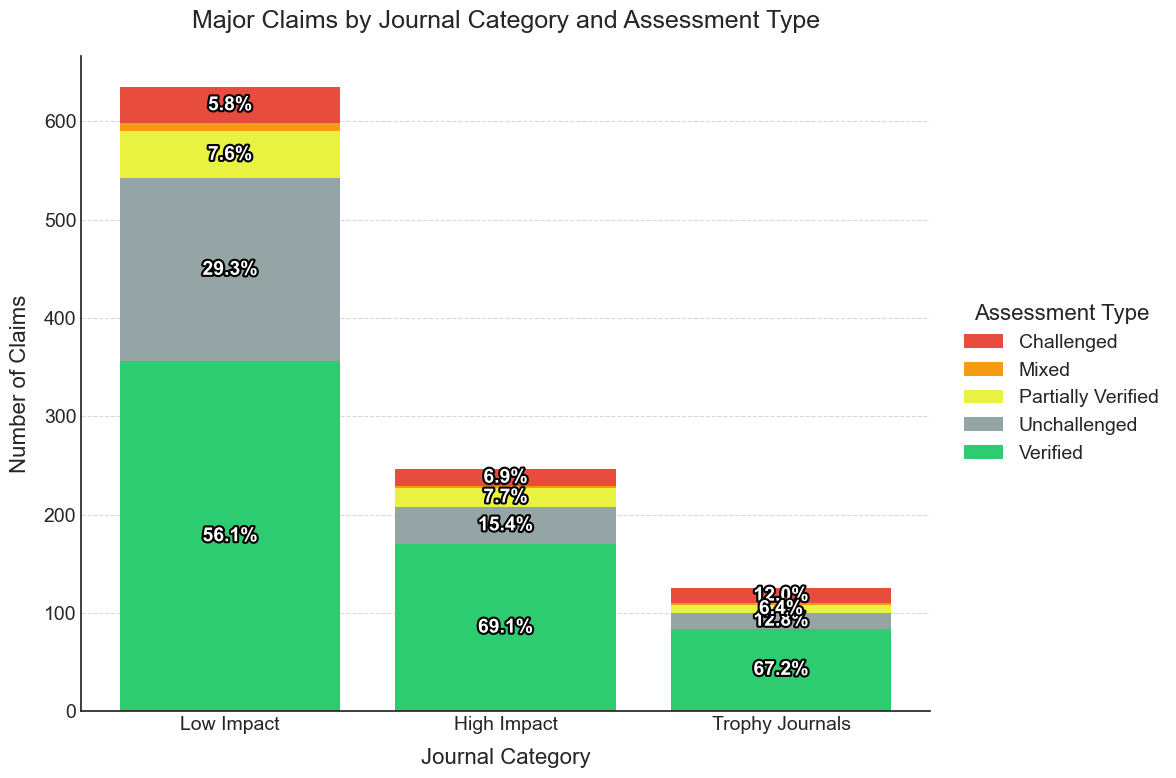

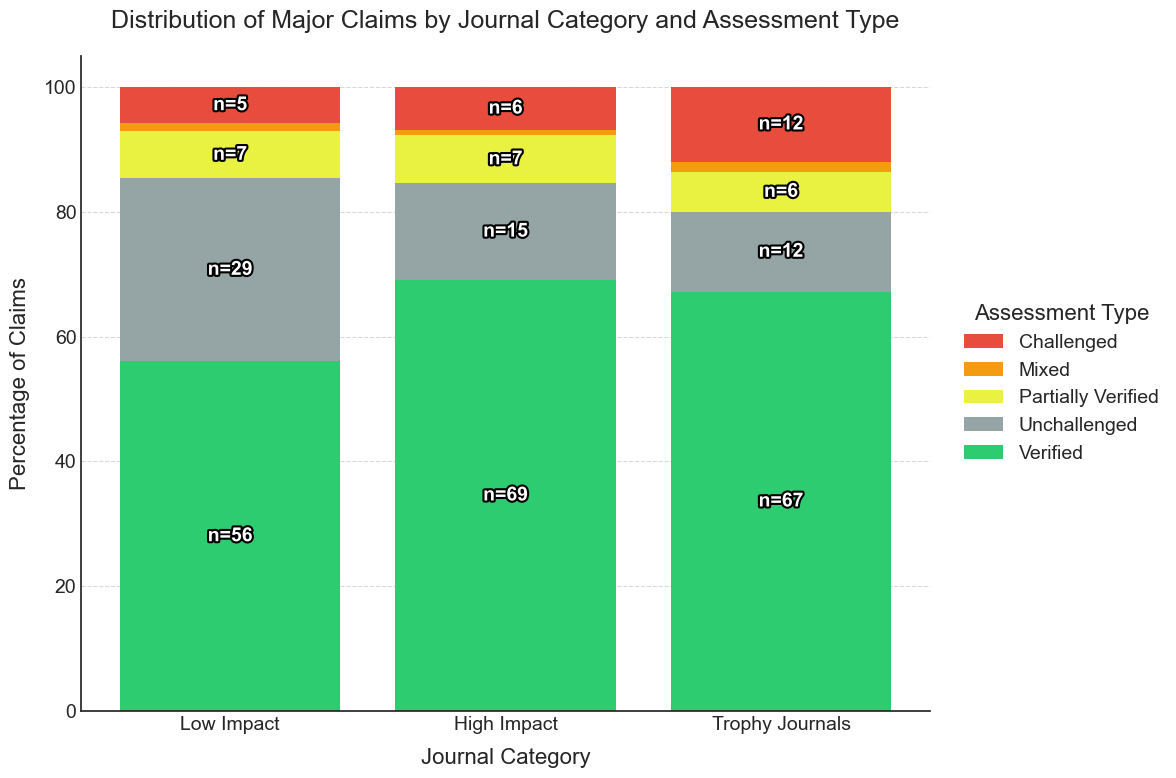

In [ ]:
# Generate and save journal category plots
fig1, ax1 = plot_info.create_stacked_bar_plot(major_claims_df, mode='absolute', by_time=False, use_expanded=False)
plt.savefig('figures/fig2_claims_journal_absolute.png', dpi=300, bbox_inches='tight')
#plt.savefig('figures/fig2_claims_journal_absolute.pdf', bbox_inches='tight')

fig2, ax2 = plot_info.create_stacked_bar_plot(major_claims_df, mode='percentage', by_time=False, use_expanded=False)
plt.savefig('figures/fig2_claims_journal_percentage.png', dpi=300, bbox_inches='tight')
#plt.savefig('figures/fig2_claims_journal_percentage.pdf', bbox_inches='tight')


 ### Time Period Analysis

1006 1006
1006 1006


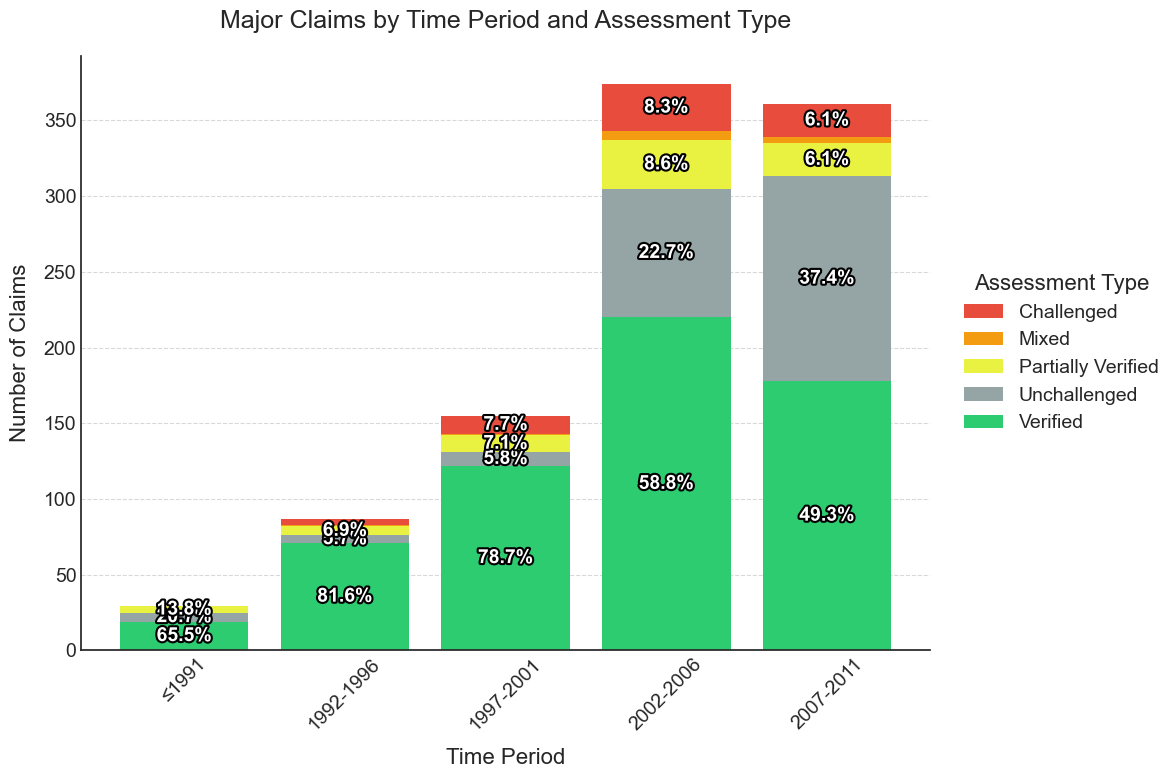

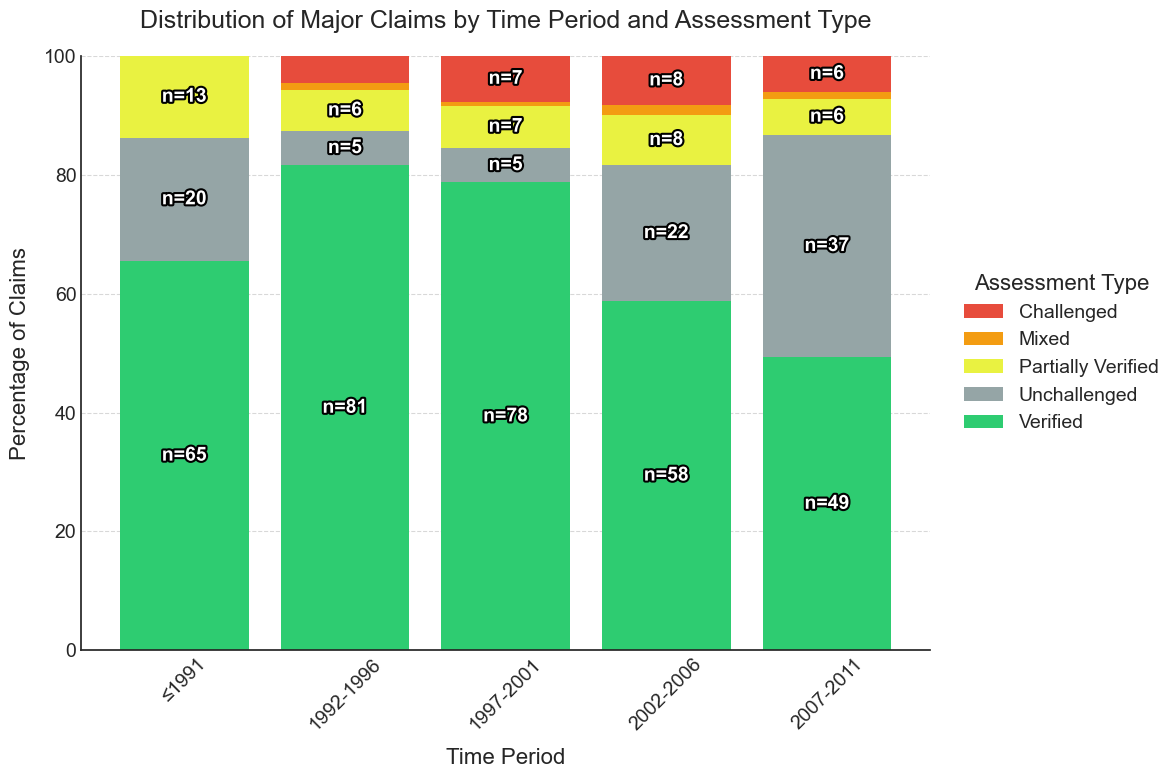

In [ ]:
# Generate and save time period plots
fig3, ax3 = plot_info.create_stacked_bar_plot(major_claims_df, mode='absolute', by_time=True)
plt.savefig('figures/fig3_claims_time_absolute.png', dpi=300, bbox_inches='tight')
#plt.savefig('figures/claims_time_absolute.pdf', bbox_inches='tight')

fig4, ax4 = plot_info.create_stacked_bar_plot(major_claims_df, mode='percentage', by_time=True)
plt.savefig('figures/fig3_claims_time_percentage.png', dpi=300, bbox_inches='tight')
#plt.savefig('figures/claims_time_percentage.pdf', bbox_inches='tight')


 ### Trophy Journals Analysis

 ## Sankey Diagram

In [ ]:
# Create Sankey diagram
to_plot = major_claims_df[["assertion_type", "label", "assessment_type", "rank_assessment_type"]]
fig = create_sankey_diagram(to_plot)
fig.show()
fig.write_html('figures/claims_sankey.html')

NameError: name 'ASSESSMENT_COLORS' is not defined